In [23]:
import geopandas as gpd
import rioxarray as rxr
from rasterio.features import shapes
import numpy as np
from shapely.geometry import shape

In [16]:
suitable = rxr.open_rasterio("suitable_pv_2022.tif").squeeze()
mask = suitable.values == 1

geoms = []
for geom, val in shapes(mask.astype(np.uint8), mask=None, transform=suitable.rio.transform()):
    if val == 1:
        geoms.append(shape(geom))

gdf = gpd.GeoDataFrame(geometry=geoms, crs=suitable.rio.crs)
gdf["area_ha"] = gdf.to_crs(32719).area / 10000  # UTM19S para área en m²→ha
gdf = gdf[gdf["area_ha"] >= 1.0]                 # umbral mínimo
gdf.to_file("pv_patches.shp")


In [17]:
import geopandas as gpd
gdf = gpd.read_file("pv_patches.shp")
print(gdf.head())
print(gdf.crs)   # asegúrate que esté en EPSG:32719


    area_ha                                           geometry
0  1.106206  POLYGON ((371135.316 6429660.405, 371189.628 6...
1  2.138666  POLYGON ((366355.786 6429606.093, 366464.412 6...
2  3.318619  POLYGON ((371977.164 6429660.405, 372031.477 6...
3  1.622436  POLYGON ((374285.46 6429660.405, 374312.616 64...
4  1.327448  POLYGON ((361929.291 6429551.78, 362065.073 64...
EPSG:32719


In [18]:
gdf["area_ha"] = gdf.to_crs(32719).area / 10000
gdf = gdf[gdf["area_ha"] >= 10]


In [19]:
gdf["area_km2"] = gdf["area_ha"] / 100
gdf["energy_cap_max_MW"] = gdf["area_km2"] * 60


In [20]:
centroids = gdf.centroid.to_crs(4326)
gdf["lon"] = centroids.x
gdf["lat"] = centroids.y


In [21]:
gdf[["lon","lat","area_km2","energy_cap_max_MW"]].to_csv("pv_sites_candidates.csv", index=False)


In [14]:
gdf.to_file("pv_sites_candidates.gpkg", layer="pv_sites", driver="GPKG")


In [22]:
import geopandas as gpd
import numpy as np
import pandas as pd

# 1) Cargar shapefile de parches
gdf = gpd.read_file("pv_patches.shp").to_crs(32719)  # UTM 19S para área

# 2) Calcular área de cada parche (ha, km²)
gdf["area_ha"] = gdf.area / 10000
gdf["area_km2"] = gdf["area_ha"] / 100

# ⚠️ OPCIONAL: filtrar parches pequeños (<10 ha)
gdf = gdf[gdf["area_ha"] >= 10]

# 3) Capacidad máxima de cada parche
DENSITY_MW_PER_KM2 = 60
gdf["energy_cap_max_MW"] = gdf["area_km2"] * DENSITY_MW_PER_KM2

# 4) Si tienes CF por parche (ej. columna "cf_mean"):
#    calcular promedio ponderado por área
if "cf_mean" in gdf.columns:
    cf_weighted = np.average(gdf["cf_mean"], weights=gdf["area_km2"])
else:
    cf_weighted = np.nan  # opcional

# 5) Consolidar todo en un único “super-sitio”
total_area_km2 = gdf["area_km2"].sum()
total_energy_cap = gdf["energy_cap_max_MW"].sum()

# Para la localización: usar el centroide global (ponderado por área)
centroid = gdf.centroid.to_crs(4326)
lon = np.average(centroid.x, weights=gdf["area_km2"])
lat = np.average(centroid.y, weights=gdf["area_km2"])

# 6) Exportar a CSV para Calliope
df_out = pd.DataFrame([{
    "site_id": "PV_SUPER",
    "lon": lon,
    "lat": lat,
    "area_km2": total_area_km2,
    "energy_cap_max_MW": total_energy_cap,
    "cf_mean": cf_weighted
}])
df_out.to_csv("pv_site_representative.csv", index=False)

print(df_out)


    site_id        lon        lat     area_km2  energy_cap_max_MW  cf_mean
0  PV_SUPER -71.026503 -32.788658  2656.108443      159366.506563      NaN


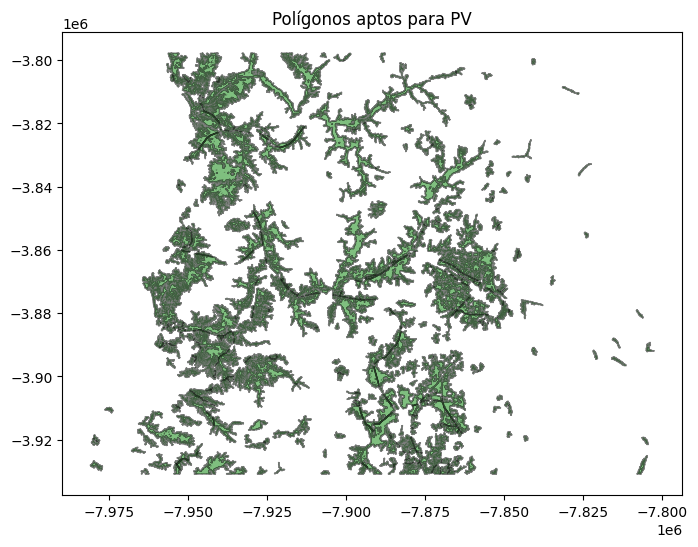

In [14]:
import matplotlib.pyplot as plt

gdf = gdf[gdf["area_ha"] >= 10]

# Graficar
fig, ax = plt.subplots(figsize=(8,8))
gdf.plot(ax=ax, color="green", edgecolor="black", alpha=0.5)

ax.set_title("Polígonos aptos para PV")
plt.show()


filtro adicional para priorizar solo los polígonos que caen en zonas de mayor recurso solar.